In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
# Load the 1-year and 3-year US treasury rates and the S&P-500 index
raw_data = pd.read_pickle(Path(os.getcwd() + "/Datasets/data/stock_data.pkl"))
raw_data.head()

,1 YEAR,3 YEAR,S&P
Date,,,
1988-01-04,7.15,8.03,256.01
1988-01-05,7.11,7.99,258.77
1988-01-06,7.14,8.03,259.03
1988-01-07,7.13,8.03,261.21
1988-01-08,7.24,8.16,243.54


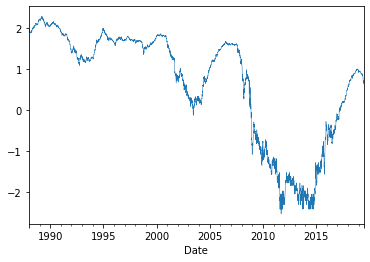

In [3]:
# Extract and take a look at the 1-year treasury log rate. 
oneyear_log = np.log(raw_data['1 YEAR'])
oneyear_log.plot(linewidth=0.5)

In [4]:
print("p-value of non-stationarity: {}".format(round(adfuller(oneyear_log)[1],4)))

p-value of non-stationarity: 0.6822


p-value of non-stationarity: 4.834395184359277e-28


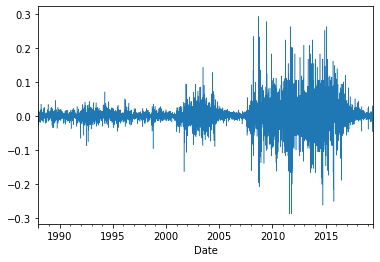

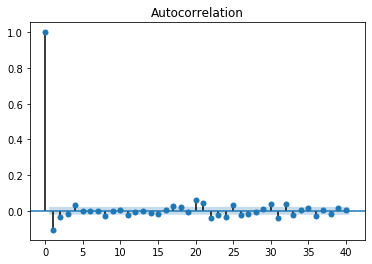

In [5]:
# Try taking the integration of order 1 of the log-rates to obtain stationarity. 
oneyear_log_diff = oneyear_log.diff(periods=1)
# Remove first value since it's NaN
oneyear_log_diff = oneyear_log_diff[1:]
oneyear_log_diff.plot(linewidth=0.5)
plot_acf(oneyear_log_diff)
# plot_acf apparantly displays two graphs if put on the last line, 
# the line below is just so we only get one display. 
print("p-value of non-stationarity: {}".format(adfuller(oneyear_log_diff)[1]))

When taking a time difference of order one, it seems like we can assume stationarity. Let's now try modelling on one year of data and test on three months.

In [6]:
start_date_train = datetime(2010,1,1)
end_date_train = datetime(2013,1,1)
end_date_test = datetime(2013,4,1)
train = oneyear_log[(oneyear_log.index > start_date_train) & (oneyear_log.index <= end_date_train)]
test = oneyear_log[(oneyear_log.index > end_date_train) & (oneyear_log.index <= end_date_test)]
print(f"Training samples: {train.size}")
print(f"Test samples: {test.size}")
n_train = train.size
n_test = test.size

Training samples: 782
Test samples: 64


#### Simple AR-model on the original data

In [7]:
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
model_ar = AR(train)
model_ar_fit = model_ar.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


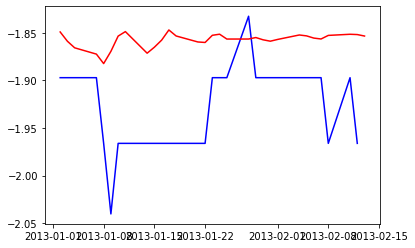

In [8]:
pred_range = 30
predictions_ar = model_ar_fit.predict(start=n_train, end=n_train+pred_range)
plt.plot(test[:pred_range],color="blue")
plt.plot(predictions_ar,color="red")

Not too good. Trying the ARIMA-model. 
#### ARIMA model 


In [9]:
from statsmodels.tsa.arima_model import ARIMA
# Need to specify p, d and q. 
p = 1 # Order
d = 1 # Integrated order, i.e. how many timesteps differencing
q = 1 # Moving average periods 
model_arima = ARIMA(train, order=(p,d,q))
model_arima_fit = model_arima.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


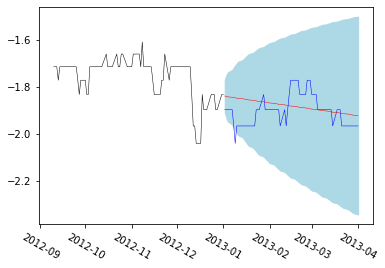

In [10]:
steps = n_test
results_arima = model_arima_fit.forecast(steps=steps,alpha=0.25)
predictions_arima = pd.DataFrame(results_arima[0], index = test.index[:steps])
plt.plot(train[700:],color="black",linewidth=0.5)
plt.plot(test[:steps],color="blue",linewidth=0.5)
plt.plot(predictions_arima,color="red",linewidth=0.5)
plt.fill_between(test.index[:steps],results_arima[2][:,0], results_arima[2][:,1],color="lightblue")
plt.xticks(rotation=-30)
plt.show()

Let's try using all the data to train and predict from 2014 and onwards. 

In [11]:
start_date_train = datetime(1988,1,4)
end_date_train = datetime(2014,1,1)
end_date_test = datetime(2014,12,1)
train = oneyear_log[(oneyear_log.index > start_date_train) & (oneyear_log.index <= end_date_train)]
test = oneyear_log[(oneyear_log.index > end_date_train) & (oneyear_log.index <= end_date_test)]
print(f"Training samples: {train.size}")
print(f"Test samples: {test.size}")
n_train = train.size
n_test = test.size
print("Training on data from {} to {} and predicting to {}.".format(start_date_train.strftime("%b %Y"),
                                                                   end_date_train.strftime("%b %Y"),
                                                                   end_date_test.strftime("%b %Y")))

Training samples: 6782
Test samples: 238
Training on data from Jan 1988 to Jan 2014 and predicting to Dec 2014.


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  % freq, ValueWarning)


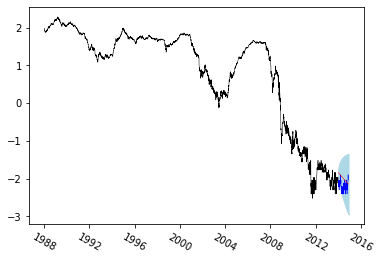

In [12]:
m2_arima = ARIMA(train,order=(1,1,1))
m2_arima_fit = m2_arima.fit() 
steps = n_test
results_arima = model_arima_fit.forecast(steps=steps,alpha=0.25)
predictions_arima = pd.DataFrame(results_arima[0], index = test.index[:steps])
plt.plot(train,color="black",linewidth=0.5)
plt.plot(test[:steps],color="blue",linewidth=0.5)
plt.plot(predictions_arima,color="red",linewidth=0.5)
plt.fill_between(test.index[:steps],results_arima[2][:,0], results_arima[2][:,1],color="lightblue")
plt.xticks(rotation=-30)
plt.show()